# 0. Import libraries

In [1]:
import os
import re
import sys
import copy
import math
import time
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
from collections import Counter
import matplotlib.pyplot as plt
import igraph as iG

from config.config import Config
cf = Config()

import importlib
def reload_module(module):
    importlib.reload(module)

# 1. Build Knowledge Base
* * *
**Notes**:
* The scope of the data we will use is mostly `SY 2023-2024` to match the available data private schools have.
* To build our network, we use the following datasets from the Department of Education (DepEd) for public and private in order of importance:
    * Longitude and Latitude (as of SY 23-24)
    * SY 23-24 Enrollment
    * SY 23-24 Furnitures, namely Seats
    * SY 23-24 Public Shifting Schedule
    * SY 23-24 SHS School Offerings
    * SY 23-24 ESC Slots
    * SY 24-25 ESC & SHS VP (GASTPE) delivering Private Schools
    * SY 24-25 GASTPE Top-ups
    * SY 24-25 ESC Tagged Learners in LIS

In [2]:
from modules import datasets

In [3]:
s_time = time.time()

kb = datasets.KnowledgeBase(load_knowledge_base=True)
e_time = time.time() - s_time

print(f"Time elapsed for building knowledge base: {(e_time / 60):.2f} minutes")

Loading public school coordinates as of SY 2023-2024.
Time elapsed for public school coordinates: 7.28 seconds

Loading private school coordinates as of 2024.
Time elapsed for private school coordinates: 5.23 seconds

Loading public and private school enrollment & SHS offerings for SY 2023-2024.
Time elapsed for enrollment & SHS offerings: 7.37 seconds

Loading public & private school furnitures, namely seats, for SY 2023-2024.
Time elapsed for public & private seats: 18.35 seconds

Loading public school shifting schedule for SY 2023-2024.
Time elapsed for public shifting: 53.44 seconds

Loading private school ESC and SHS VP delivering schools as of 2024.
Time elapsed for public shifting: 1.49 seconds

Time elapsed for building knowledge base: 1.55 minutes


# 2. Prepare Map Resources
* * *
We mainly use the `osmnx` Python library to query and locally save the graph networks of roads (and walkable paths) that will be used to build our network of schools.

Based on experience, only specialized and high-power machines are able to query the graph network of the entire Philippines in one call. Given the limitations of the machine used in this project, we broke our `osmnx` graph network queries by region and stored them locally in the directory `data/networks/regional_drive_graphs`. The relevant regional graph networks for this research are Region III, Region IV-A, Region V, and NCR.

In [4]:
from modules import map_resources

In [5]:
s_time = time.time()

# Initialize class that also preloads and reorganizes PSGC shapefiles
mr = map_resources.MapResources(preloaded=False)

# The gpd_gadm is the dataframe of the shapefiles of Philippines following PSGC with EPSG:4326
gpd_gadm = mr.gadm.copy()

# The output is a dictionary of complete filepaths where the keys are the PSGC region names
# of our 17 regions. These are OSMNX drive graph networks
mr.get_filepaths_of_regional_road_networks()

# Additional preprocessing is done on our compiled public & private datasets
public = kb.compile_public_datasets()
private = kb.compile_private_datasets()

gdf_public = mr.preprocess_public_school_coordinates_further(public)
gdf_private = mr.preprocess_private_school_coordinates_further(private)

e_time = time.time() - s_time
print(f"Time elapsed for preparing map resources: {(e_time / 60):.2f} minutes")

Time elapsed for preparing map resources: 1.00 minutes


# 3. Graph Network Generation
* * *
We will use our `optimized_network_builder` module to facilitate the preparation and generation of the graph network of our schools using our compiled knowledge base and organized shapefiles. We provide a high-level overview below of how the project generates a graph network of schools.

<dl>
    Given the PSGC code of a target region:
    <ol type="1">
      <li>We get the shapefiles/geographies of the target region and its adjacent localities</li>
      <li>Using the above shapefiles, we extract the public schools in the target region and extract private schools that fall within the target and adjacent areas</li>
      <li>Still using the shapefiles, we cutout the drive network from our preloaded & locally saved OSMNX graph networks</li>
      <li>Feed the following to our network builder:
        <ol type="1">
          <li>Target & adjacent shapefiles</li>
          <li>Public and private schools</li>
          <li>Drive graph network</li>
        </ol>
      </li>
      <li>Run network builder algorithm</li>
    </ol>
</dl>

## 3.1. Parameter setting

We extract the shapes of our target geography and its adjacent geographies. `max_depth` here determines how far the algorithm will crawl outward from the target region when extracting adjacent geographies.

In [6]:
# As mentioned in the paper, we use the geographic code of Region IV-A
target_psgc = '0400000000'
max_depth = 3
geo_results = mr.get_adjacent_geographies(
    gpd_gadm=gpd_gadm, 
    target_psgc=target_psgc, 
    max_depth=max_depth
)
print()

# Extracting schools using extracted geographies
school_results = mr.extract_schools_from_geographies(
    geography_results=geo_results,
    gdf_public=gdf_public,
    gdf_private=gdf_private
)
print()

Finding adjacent geographies for PSGC 0400000000 with max_depth=3
Detected administrative level: region
Finding adjacent areas at depth 1...
Found 62 adjacent areas at depth 1
Finding adjacent areas at depth 2...
Found 101 adjacent areas at depth 2
Finding adjacent areas at depth 3...
Found 136 adjacent areas at depth 3
Geography processing completed in 8.92 seconds

Extracting schools from geographies...
Prepared geometries in 0.00 seconds
Extracting public schools...
Public target query completed in 0.07 seconds
Found 3548 public schools in target area
Public adjacent depth 1 query completed in 0.02 seconds
Found 118 public schools in adjacent areas at depth 1
Public adjacent depth 2 query completed in 0.02 seconds
Found 174 public schools in adjacent areas at depth 2
Public adjacent depth 3 query completed in 0.02 seconds
Found 203 public schools in adjacent areas at depth 3
Extracting private schools...
Private search area query completed in 351.06 seconds
Found 2653 private school

In [7]:
%%time
# We cull a subgraph from locally saved regional drive graph networks
G_sub = mr.generate_subgraph(geo_results)

Generating subgraph from geo_results
Subgraph extracted. Time elapsed: 4.04 minutes
CPU times: user 3min 49s, sys: 5.01 s, total: 3min 55s
Wall time: 4min 3s


In [8]:
# We explicitly identify the major groups that will comprise the school network
# This will be removed in the future since we will connect schools with each other regardless of groups
public_in_city = school_results['public_schools_in_target'].copy()

# My private dataframe has columns with "validated" coordinates - we explicitly call them here
private_in_space = school_results['private_schools_in_target'].copy()
private_in_space = private_in_space.drop(columns=['longitude','latitude'])
private_in_space = private_in_space.rename(
    columns={'longitude_valid':'longitude', 'latitude_valid':'latitude'}
)

# Public schools adjacent
adjacent_dfs = [v for k,v in school_results['public_schools_in_adjacent'].items()]
public_periph = pd.concat(adjacent_dfs)

# Private schools adjacent
adjacent_dfs = [v for k,v in school_results['private_schools_in_adjacent'].items()]
private_periph = pd.concat(adjacent_dfs)
private_periph = private_periph.drop(columns=['longitude','latitude'])
private_periph = private_periph.rename(
    columns={'longitude_valid':'longitude', 'latitude_valid':'latitude'}
)

# A dataframe of adjacent PUBLIC and PRIVATE schools
all_periph = pd.concat([public_periph, private_periph])

## 3.2. Graph Generation Algorithm

In [9]:
from modules import optimized_network_builder as onb

In [10]:
# Initialize the optimized builder
network_builder = onb.OptimizedSchoolNetworkBuilder(
    road_network_graph=G_sub,
    public_schools_gdf=public_in_city.reset_index(),
    private_schools_gdf=private_in_space.reset_index(),
    peripheral_schools_gdf=all_periph.reset_index(),
    admin_boundary=geo_results['target_area'],
    num_processes=None  # None means parallelization will use all available CPUs
)

In [11]:
# # Build the complete network in one call
# results = network_builder.build_complete_network(
#     buffer_distance_m=5000,
#     max_distance_km=15
# )

In [12]:
load_path = os.path.join(cf.get_path("output"), "gnet_dist_NCR4A_07-30-2025.pkl")
with open(load_path, 'rb') as file: # Open the file in binary read mode ('rb')
    results = pickle.load(file) # Load the dictionary from the file
    
graph = results
count_nodes = len(graph.vs)
count_edges = len(graph.es)
print(f"Number of nodes: {count_nodes}")
print(f"Number of nodes: {count_edges}")

Number of nodes: 8102
Number of nodes: 1091004


## 3.3. Visualization of Graph Network

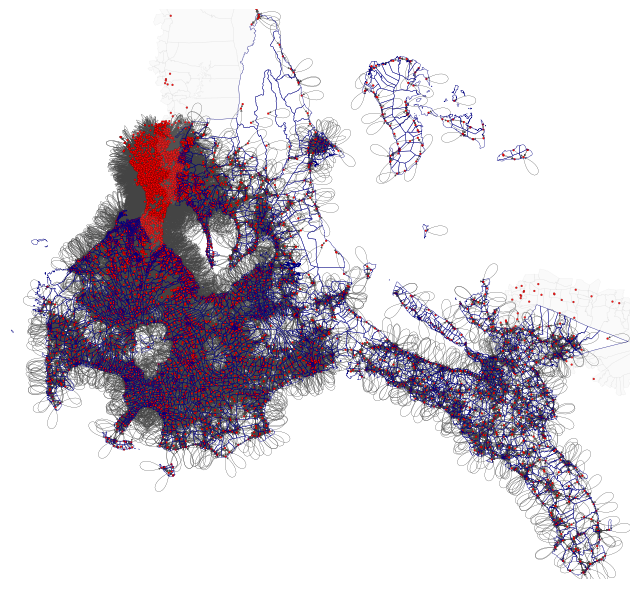

CPU times: user 8min 26s, sys: 1.81 s, total: 8min 28s
Wall time: 8min 27s


In [23]:
%%time
# Sanity check if we capture our schools in Region IV-A
fig, ax = plt.subplots(figsize=(8,8))

mult_savefig = 1
# Plot network anchored on the schools' lon-lat
iG.plot(
    results,
    target=ax,
    vertex_size=2*mult_savefig,
    vertex_frame_width=.1,
    edge_width=.1,           # Make edges thicker
    edge_arrow_size=2*mult_savefig,      # Control arrow size
    edge_arrow_width=2*mult_savefig,     # Control arrow width
    bbox=(1000,1000),
    margin=0
)

geo_results['target_area'].to_crs(3123).plot(
    ax=ax, facecolor='none', edgecolor='navy',
    linewidth=.25, alpha=1,
)

df_adjs = []
for k, v in geo_results['adjacent_areas'].items():
    df_adj = geo_results['adjacent_areas'].get(k)
    df_adj.to_crs(3123).plot(
        ax=ax, facecolor='lightgray', edgecolor='grey',
        linewidth=.25, alpha=.1
    )
    df_adjs.append(df_adj.to_crs(3123))
df_adjs = pd.concat(df_adjs)

df_cm = geo_results['target_area'].to_crs(3123).copy()
cm_3123_shp = df_cm.unary_union # This is 4326

min_x, min_y, max_x, max_y = cm_3123_shp.bounds
multiplier = 0.001
ax.set_xlim(min_x*(1 - multiplier), max_x*(1 + multiplier))
ax.set_ylim(min_y*(1 - multiplier), max_y*(1 + multiplier))

plt.show()
plt.close()

# 4. Experiments

## 4.1. Results of Deterministic Algorithms

In [24]:
from modules import experiments

In [25]:
geography = {"level":"region", "name":["Region IV-A"]}
exp = experiments.Experiments(graph, kb, geography)

In [26]:
pkg = exp._initialize_experiment()
print(f"Overall congestion without incomning Grade 7 students: {pkg['current_jhs_congestion']}")
print(pkg.keys())

Overall congestion without incomning Grade 7 students: 1.5646315724992423
dict_keys(['g6_enrollment', 'distribution_graph', 'filters', 'public_jhs', 'esc_jhs', 'current_jhs_congestion', 'esc_slots'])


In [27]:
baseline_score = exp.run_baseline_experiment(pkg)
baseline_jhs, baseline_total = exp.track_actual_jhs_enrollment(pkg['distribution_graph'])
print(f"{baseline_total:,}")
print(f"Overall congestion when ALL incoming Grade 7 students enroll in public high schools only: {baseline_score}")

297,498
Overall congestion when ALL incoming Grade 7 students enroll in public high schools only: 2.1515462410026913


In [28]:
pkg = exp._initialize_experiment()
redist = exp.run_redistribution_experiment(pkg)
print(redist.keys())

pkg["g6_enrollment"] = redist['redistributed_g6_enrollment']
redist_score = exp.run_baseline_experiment(pkg)
redist_jhs, redist_total = exp.track_actual_jhs_enrollment(pkg['distribution_graph'])
print(f"{redist_total:,}")
print(f"Overall congestion when a portion of incoming Grade 7 students are redirected to private schools participating in ESC: {redist_score}")

dict_keys(['redistribution_results', 'redistributed_g6_enrollment', 'involved_es_school_ids'])
254,467
Overall congestion when a portion of incoming Grade 7 students are redirected to private schools participating in ESC: 2.0842791375046574


In [29]:
looped_optimization = exp.run_looped_esc_slot_optimization(max_iterations=10)
print(looped_optimization.keys())
print(f"\nOverall congestion when the allocation of slots in ESC schools are optimized: {looped_optimization['final_congestion_score']}")


🔁 Iteration 1/10
📉 Congestion Score: 2.084279

🔁 Iteration 2/10
📉 Congestion Score: 2.051309
✅ Slot allocation converged. Stopping early.

📊 Optimization History:
  Iter 1: 2.084279
  Iter 2: 2.051309
dict_keys(['final_congestion_score', 'iterations', 'history', 'optimized_esc_slots', 'total_jhs_enrollment', 'jhs_enrollment_by_school'])

Overall congestion when the allocation of slots in ESC schools are optimized: 2.0513085046597257


## 4.2 Finalized Results

In [30]:
index = [
    'Baseline Distribution',
    'Student Redistribution',
    'Optimized Allocation',
]
values = [
    np.round(baseline_score, 3),
    np.round(redist_score, 3),
    np.round(looped_optimization['final_congestion_score'], 3)
]
columns = ['Metric']

df_results = pd.DataFrame(
    index=index,
    data=values,
    columns=columns
)

In [31]:
df_results

,Metric
Baseline Distribution,2.152
Student Redistribution,2.084
Optimized Allocation,2.051
